# Проект

# Приоритизация гипотез, запуск A/B-теста и анализ результатов


# Часть 1. Приоритизация гипотез.

In [2]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as st
from datetime import timedelta
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
# загрузим таблицу
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.to_csv('hypothesis.csv')

In [79]:
#приведем название к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


**Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.**


In [80]:
#сделаем колонку р расчетом в фреймфорке ICE
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

In [81]:
#выведем результат в порядке убывания
hypothesis['ICE'].sort_values(ascending = False)

8    16.200000
0    13.333333
7    11.200000
6     8.000000
2     7.000000
1     2.000000
5     1.333333
3     1.125000
4     1.000000
Name: ICE, dtype: float64

**Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.**

In [82]:
#сделаем колонку р расчетом в фреймфорке ICE
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

In [83]:
#выведем результат в порядке убывания
hypothesis['RICE'].sort_values(ascending = False)

7    112.0
2     56.0
6     40.0
0     40.0
8     16.2
3      9.0
5      4.0
1      4.0
4      3.0
Name: RICE, dtype: float64

**Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.**


По фреймворку ICE в приоритете 8,0,7,6,2  
По фреймворку RICE в приоритете 7,2,6,0,8  

Состав первых пяти гипотез не изменился, но приоритет поменялся, из-за влияния параметра Reach

**Вывод: Я бы предложил тестировать три гипотезы в след. порядке: 7-0-8**



# Часть 2. Анализ A/B-теста

### 1. Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.

In [84]:
#загрузим данные
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [85]:
#приведем столбцы дат к соответствующему формату
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [86]:
#осмотрим данные
print(orders.info())
print()
print(visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None


In [87]:
orders.head(3)


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


In [88]:
visitors.head(3)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


In [89]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()
datesGroups

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [90]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = (
    datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
               .agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1)
               .sort_values(by=['date','group'])
)
ordersAggregated

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
...,...,...,...,...,...
496,2019-08-29,B,596,544,5559398
730,2019-08-30,A,545,493,4022970
690,2019-08-30,B,620,567,5774631
958,2019-08-31,A,557,503,4084803


In [91]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = (
    datesGroups
    .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)
visitorsAggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
496,2019-08-29,B,17708
730,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [92]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cummulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cummulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cummulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


##### Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

In [93]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cummulativeRevenueA = cummulativeData[cummulativeData['group']=='A'][['date','revenue', 'orders']]

In [94]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cummulativeRevenueB = cummulativeData[cummulativeData['group']=='B'][['date','revenue', 'orders']]

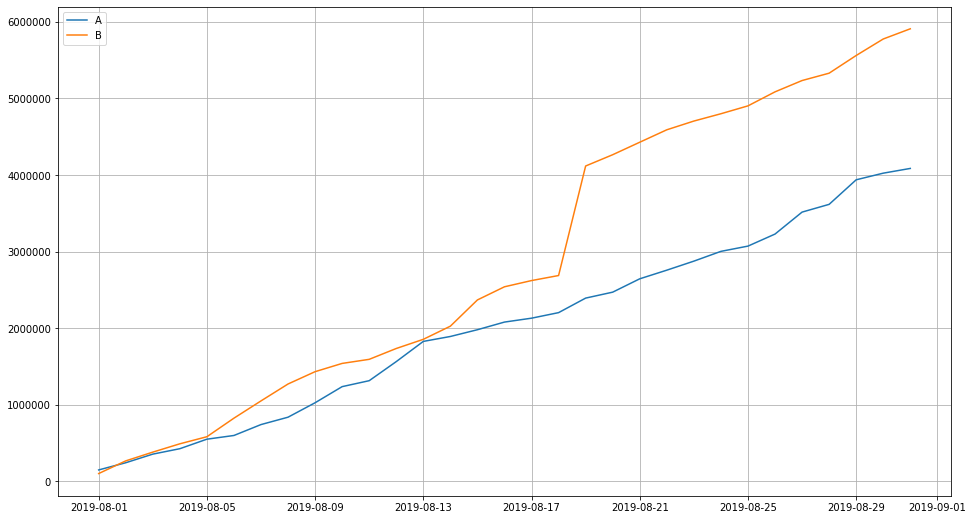

In [95]:
plt.figure(figsize=(16,9))
plt.grid(b=None, which='major', axis='both')
# Строим график выручки группы А
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue'], label='B')

plt.legend()
plt.show()

**Выручка почти равномерно увеличивается в течение всего теста. Хороший знак.  
Однако график выручки, особенно  группы B, нескольких точках резко растет. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.**


### 2. Построим график кумулятивного среднего чека по группам.  Сделаем выводы и предположения.

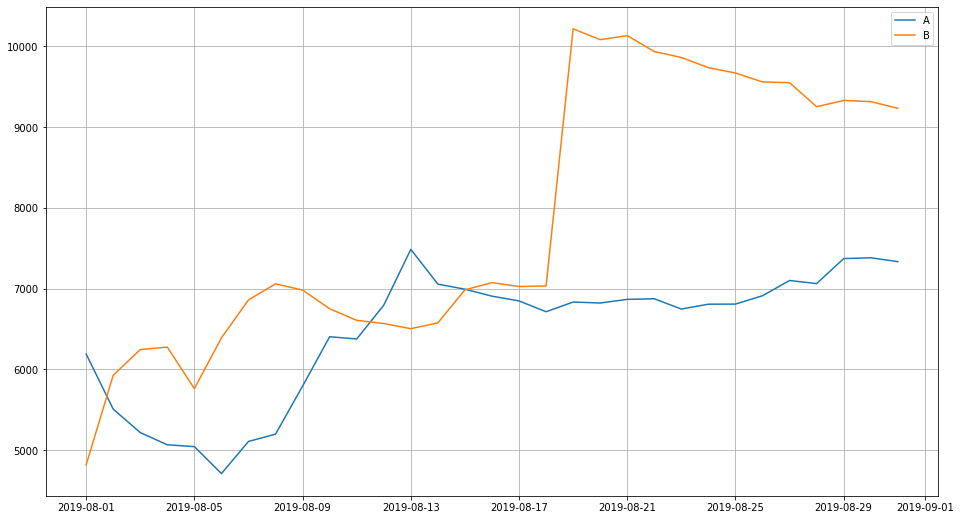

In [96]:
# Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов
plt.figure(figsize=(16,9))
plt.grid(b=None, which='major', axis='both')
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue']/cummulativeRevenueA['orders'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue']/cummulativeRevenueB['orders'], label='B')
plt.figsize = (16,9)
plt.legend()
plt.show()

##### Видно резкие всплески на графиках двух групп, что свидетельствует об аномальных средних чеках в середине теста в группе B,  и аномально низких в группе А. Толко концу теста намечается выравнивание.



### 3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.

In [97]:
# собираем данные в одном датафрейме
mergedCummulativeRevenue = cummulativeRevenueA.merge(cummulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCummulativeRevenue

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101
5,2019-08-06,598401,127,824337,129
6,2019-08-07,740818,145,1049671,153
7,2019-08-08,837097,161,1270589,180
8,2019-08-09,1025603,177,1431401,205
9,2019-08-10,1236098,193,1539203,228


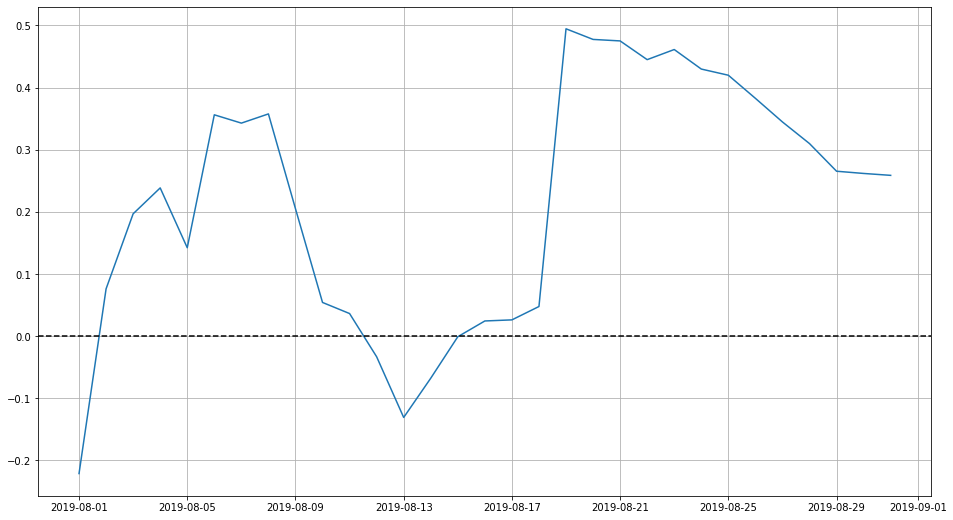

In [98]:
plt.figure(figsize=(16,9))
plt.grid(b=None, which='major', axis='both')

# cтроим отношение средних чеков
plt.plot(mergedCummulativeRevenue['date'], (mergedCummulativeRevenue['revenueB']/mergedCummulativeRevenue['ordersB'])/(mergedCummulativeRevenue['revenueA']/mergedCummulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.show()

##### В нескольких точках график различия между сегментами резко падает и растет. Это говорит о надичии выбросов в данных тестов



### 4. Построим графики кумулятивной конверсии по группам. Сделаем выводы и предположения.

In [99]:
# считаем кумулятивную конверсию
cummulativeData['conversion'] = cummulativeData['orders']/cummulativeData['visitors']
# отделяем данные по группе A
cummulativeDataA = cummulativeData[cummulativeData['group']=='A']
# отделяем данные по группе B
cummulativeDataB = cummulativeData[cummulativeData['group']=='B']

In [100]:
cummulativeData
cummulativeDataB.head()
cummulativeDataA.head() 
print(cummulativeData['date'].min())
print(cummulativeData['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


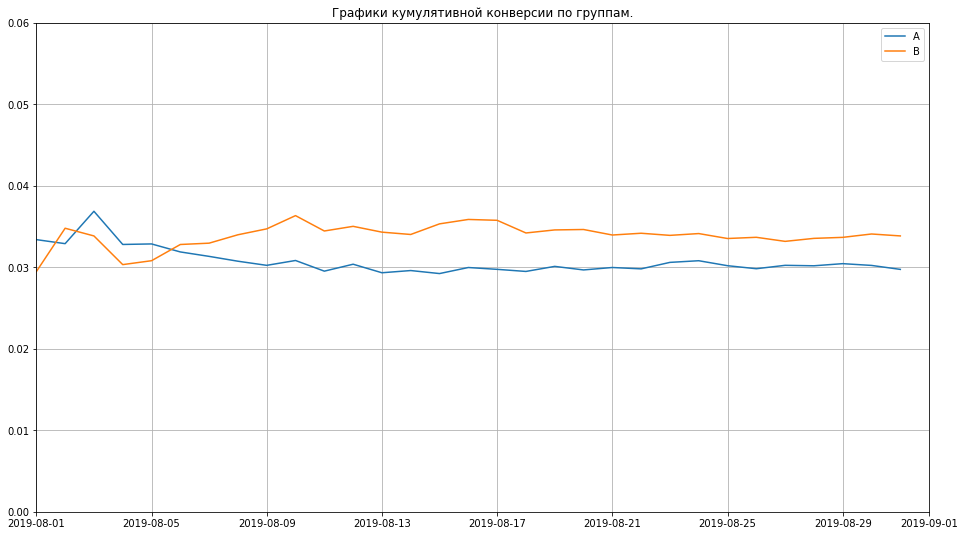

In [154]:
# строим графики
plt.figure(figsize=(16,9))
plt.grid(b=None, which='major', axis='both')
plt.plot(cummulativeDataA['date'], cummulativeDataA['conversion'], label='A')
plt.plot(cummulativeDataB['date'], cummulativeDataB['conversion'], label='B')
plt.legend()
# задаем масштаб осей
plt.axis(["2019-08-01", '2019-09-01', 0, 0.06])
plt.title('Графики кумулятивной конверсии по группам.')
plt.show()

#### Получились паралельные линии с пересечением! Группы колебались около одного значения, но затем конверсия группы B вырвалась вперёд и зафиксировалась, а конверсия группы А просела и также зафиксировалась.



### 5. Построим график относительного изменения кумулятивной конверсии группы B к группе A. Сделаем выводы и предположения.

In [102]:
# объединим таблицы по конверсиям групп
mergedCummulativeConversions = cummulativeDataA[['date','conversion']].merge(cummulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCummulativeConversions


,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793
5,2019-08-06,0.031870,0.032783
6,2019-08-07,0.031324,0.032946
7,2019-08-08,0.030731,0.033975
8,2019-08-09,0.030225,0.034699
9,2019-08-10,0.030821,0.036323


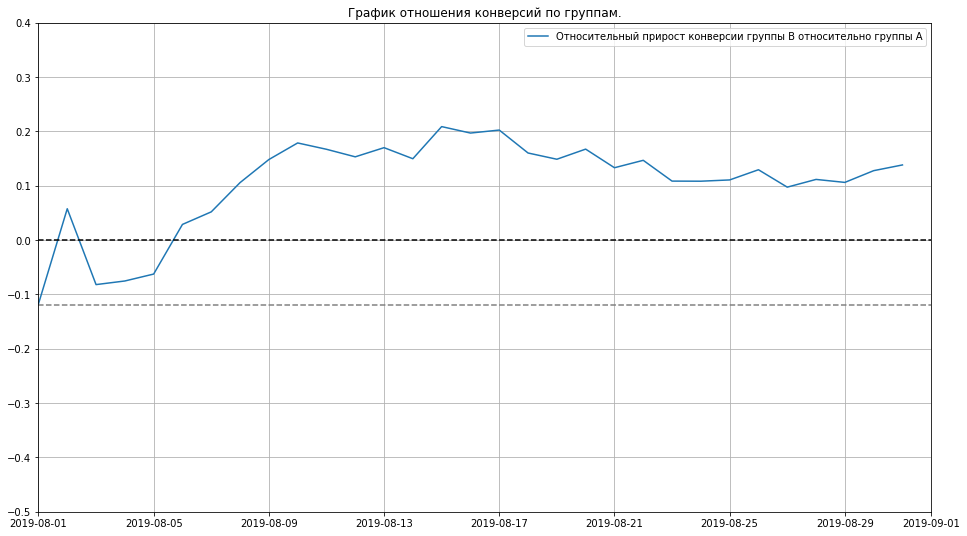

In [156]:
# построим график отношения конверсии гр В к гр А
plt.figure(figsize=(16,9))
plt.grid(b=None, which='major', axis='both')
plt.plot(mergedCummulativeConversions['date'], mergedCummulativeConversions['conversionB']/mergedCummulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.12, color='grey', linestyle='--')
plt.axis(['2019-08-01', '2019-09-01', -0.5, 0.4])
plt.title('График отношения конверсий по группам.')
plt.show()

**В начале теста график совершил несколько колебаниий, но затем uгруппа B вырвалась вперёд. Потом её конверсия снова падала, но теперь постепенно растёт.
В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя.**



### 6. Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

In [104]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [105]:
# посчитаем число заказов по пользователям
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
# переименуем столбцы
ordersByUsers.columns = ['userId','orders']
# взглянем на числа
ordersByUsers.sort_values(by='orders',ascending=False).head(10)

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


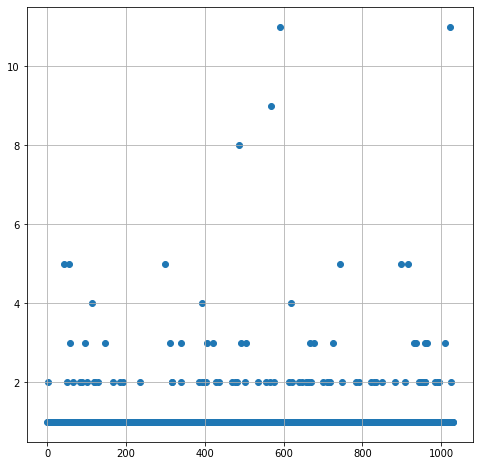

In [106]:
# построим точечную диаграмму числа заказов на одного пользователя
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(8,8))
plt.grid(b=None, which='major', axis='both')
plt.scatter(x_values, ordersByUsers['orders'])
plt.show()

**Много пользователей с 2-4 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет.**
Посчитаем выборочные перцентили количества заказов на одного пользователя.  


### 7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [107]:
#считаем перцентили
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

За границу аномальных заказов примем 2 заказа. Все что более двух - выбросы

### 8. Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

In [108]:
orders.sort_values(by='revenue',ascending=False).head(10)

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
682,1216533772,4266935830,2019-08-29,78990,B
662,1811671147,4266935830,2019-08-29,78990,A
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A


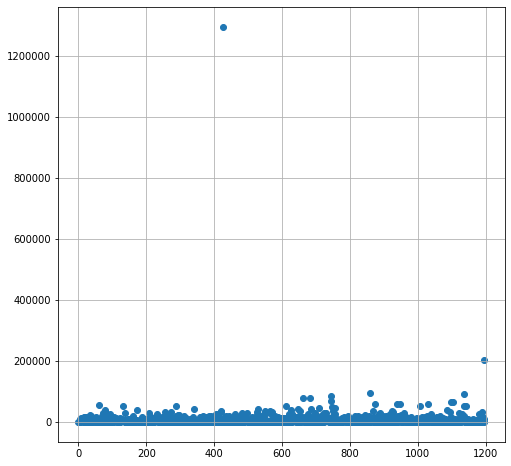

In [109]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(8,8))
plt.grid(b=None, which='major', axis='both')
plt.scatter(x_values, orders['revenue'])
plt.show()

Есть выбросы по цене, необходимо определить точнее с помощью процентилей



### 9.  Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [110]:
#считаем перцентили
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Граница аномальности проходит по 28000 

In [111]:
orders['revenue'].describe(percentiles = [0.95, 0.99])

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
50%      2.978000e+03
95%      2.800000e+04
99%      5.823320e+04
max      1.294500e+06
Name: revenue, dtype: float64

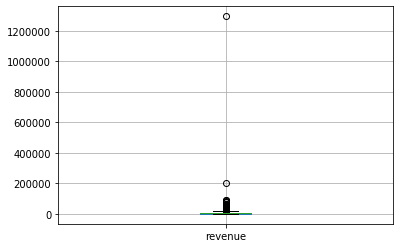

In [164]:
orders[['revenue']].boxplot()

In [177]:
# проверка значений перцентилей
orders[orders['revenue'] > 28000]['revenue'].count()/orders[['revenue']].count()

revenue    0.050125
dtype: float64

# Подготовим данные для решение следующих задач

In [113]:
visitors.head(3)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


In [122]:
orders.head(3)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


In [114]:
# количество пользователей в выбранную дату в группе A;
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsADaily


,date,visitorsPerDateA
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756
5,2019-08-06,667
6,2019-08-07,644
7,2019-08-08,610
8,2019-08-09,617
9,2019-08-10,406


In [115]:
# количество пользователей в выбранную дату в группе B;
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
visitorsBDaily

,date,visitorsPerDateB
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707
36,2019-08-06,655
37,2019-08-07,709
38,2019-08-08,654
39,2019-08-09,610
40,2019-08-10,369


In [118]:
#количество пользователей в выбранную дату в группе A;
visitorsACummulative = (visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]
                                             .agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1))
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsACummulative

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318
5,2019-08-06,3985
6,2019-08-07,4629
7,2019-08-08,5239
8,2019-08-09,5856
9,2019-08-10,6262


In [120]:
#количество пользователей в выбранную дату в группе B;
visitorsBCummulative = (visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]
                                             .agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1))
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
visitorsBCummulative

,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280
36,2019-08-06,3935
37,2019-08-07,4644
38,2019-08-08,5298
39,2019-08-09,5908
40,2019-08-10,6277


In [124]:
# сделаем таблицу с заказами и выручкой по дням group A
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
ordersADaily

,date,ordersPerDateA,revenuePerDateA
0,2019-08-01,24,148579
1,2019-08-02,20,93822
2,2019-08-03,24,112473
3,2019-08-04,16,70825
4,2019-08-05,25,124218
5,2019-08-06,18,48484
6,2019-08-07,18,142417
7,2019-08-08,16,96279
8,2019-08-09,16,188506
9,2019-08-10,16,210495


In [126]:
# сделаем таблицу с заказами и выручкой по дням по наростающей group A
ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']
ordersACummulative

,date,ordersCummulativeA,revenueCummulativeA
0,2019-08-01,24,148579
1,2019-08-02,44,242401
2,2019-08-03,68,354874
3,2019-08-04,84,425699
4,2019-08-05,109,549917
5,2019-08-06,127,598401
6,2019-08-07,145,740818
7,2019-08-08,161,837097
8,2019-08-09,177,1025603
9,2019-08-10,193,1236098


In [128]:
# сделаем таблицу с заказами и выручкой по дням group B
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
ordersBDaily

,date,ordersPerDateB,revenuePerDateB
0,2019-08-01,21,101217
1,2019-08-02,24,165531
2,2019-08-03,16,114248
3,2019-08-04,17,108571
4,2019-08-05,23,92428
5,2019-08-06,28,242342
6,2019-08-07,24,225334
7,2019-08-08,27,220918
8,2019-08-09,25,160812
9,2019-08-10,23,107802


In [129]:
# сделаем таблицу с заказами и выручкой по дням по наростающей group B
ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']
ordersBCummulative

,date,ordersCummulativeB,revenueCummulativeB
0,2019-08-01,21,101217
1,2019-08-02,45,266748
2,2019-08-03,61,380996
3,2019-08-04,78,489567
4,2019-08-05,101,581995
5,2019-08-06,129,824337
6,2019-08-07,153,1049671
7,2019-08-08,180,1270589
8,2019-08-09,205,1431401
9,2019-08-10,228,1539203


In [132]:
#объеденим все в одну таблицу
data_abtest = (
    ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
data_abtest.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


### 10. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. Сделаем выводы и предположения.

In [66]:
# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. 
#В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']
ordersByUsersA


,userId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1
...,...,...
498,4243832526,1
499,4256040402,7
500,4259830713,1
501,4266935830,1


In [69]:
# Создадим переменную ordersByUsersB
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']
ordersByUsersB


,userId,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1
...,...,...
581,4258103007,1
582,4266935830,1
583,4279090005,1
584,4281247801,1


Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [135]:
# Объявим переменные sampleA и sampleB
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data_abtest['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data_abtest['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)



In [137]:
print("{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.008
0.138


**Вывод: По «сырым» данным есть различие в конверсии групп A и B.
Первое число — p-value = 0.008 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет,  отвергаем. Однако относительное преимущество группы B равен 13.8%.**



### 11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.

In [139]:
# относительные различия в среднем чеке между группами:
print("{0:.3f}".format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.365
0.259


**P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.**



### 12. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделаем выводы и предположения.

Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 28 000 . Так мы уберём 5% пользователей с наибольшим числом заказов и пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 28 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers

In [144]:
# сделаем срез по кол-ву заказов
usersWithManyOrders = (pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], 
                                  ordersByUsersB[ordersByUsersB['orders'] > 4]['userId']], axis = 0))
# сделаем срез по сумме заказов
usersWithExpensiveOrders = orders[orders['revenue'] > 20000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print()
print(abnormalUsers.shape)

568     113298937
1099    148427295
461     154576532
18      199603092
928     204675465
dtype: int64

(94,)


всего 94 аномальных пользователя

In [163]:
#подготовим очищенные выборки количества заказов по пользователям по группам теста:

sampleAFiltered = (pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId']
                .isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data_abtest['visitorsPerDateA']
                .sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
                  )

sampleBFiltered = (pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId']
                .isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data_abtest['visitorsPerDateB']
                .sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)
                  )

sampleAFiltered.value_counts()

0    18233
1      434
2       14
Name: orders, dtype: int64

In [149]:
#Применим статистический критерий Манна-Уитни к полученным выборкам:
print("{0:.3f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.008
0.203


Результаты по конверсии изменились в большую сторону, на 20 процентов конверсия выше в группе В



### 13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения

In [153]:
# различие по среднему чеку
print("{0:.3f}".format(st.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

0.383
-0.023


(было 0.365
     0.259)
     
**p-value почти не изменилось, а вот средний чек стал почти одинаков, в группе А стал чуть больше. Что подвержается значением p-value**



### 14. Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест

Предварительные итоги:  
Конверсия:
 - конверсия ДО исключения выбросов: ( p-value = 0.008, convB/convA = 0.138);  
 - конверсия ПОСЛЕ исключения выбросов: ( p-value = 0.008, convB/convA = 0.203);  
Средний чек:
 - ДО исключения выбросов: ( p-value = 0.365, avgB/avgA = 0.259)
 - ПОСЛЕ исключения выбросов:( p-value = 0.383, avgB/avgA = - 0.023)
Исследовав результаты,можно сделать следующие выводы:
  1. По конверсии показатель статистической значимости говорит о принятии альтернативной гипотезы - неравности средних конверсии, что подтверждаетися отношением конверсий двух групп  и установившемся графике конверсий и графике отношения конверсий.  
  2. По среднему чеку показатель статистической значимости говорит о принятии нулевой гипотезы - равенства среднего чека двух групп, что подверждается отношением средних двух групп стремящимся к 0. По графику из-за наличия выбросов сделать никаких выводов нельзя
  
 

  
  

# Вывод

###  Остановить тест, зафиксировать победу одной из групп.

Конверсия группы B выросла на 20 %  
Средний чек остался без изменений

